## Importing essential libraries

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam


## Loading the data set

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
folder_path = '/content/drive/My Drive/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

## Preproccesing and augmentation

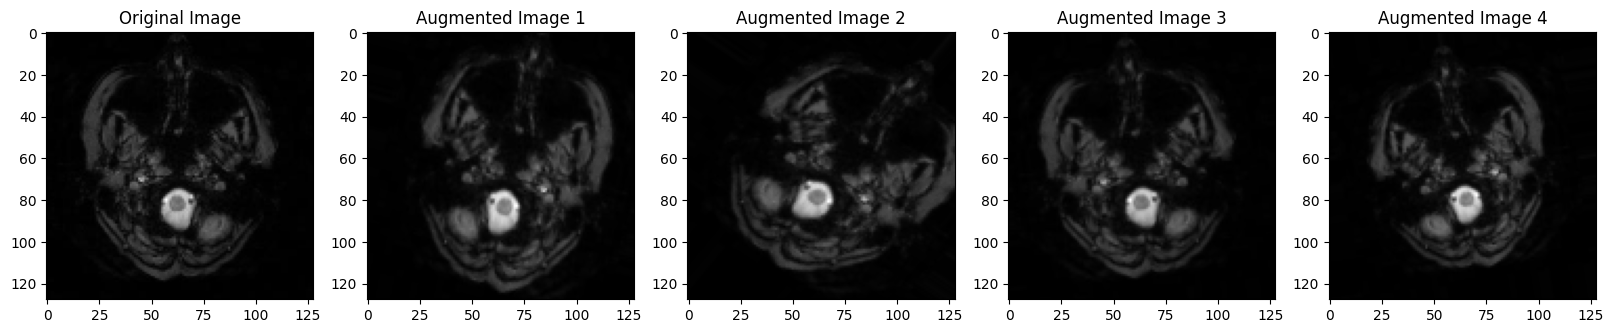

Finished processing images for label 'MCI'.
Number of images for label 'MCI': 3445
Finished processing images for label 'AD'.
Number of images for label 'AD': 4825
There are 8270 images in the 'images' variable.
There are 8270 image labels in the 'image_labels' variable.
There are 2 unique labels in the 'image_labels_encoded' variable.
The unique labels are: [0 1]
The counts of each label are: [4825 3445]


In [23]:
image_dir = folder_path

labels = ["MCI", "AD"]

image_size = (128, 128)

rescale = 1./255

augmentation_params = dict(horizontal_flip=True, shear_range=0.2, height_shift_range=0.1, rotation_range=45, zoom_range=[0.9, 1.1])

images = []
image_labels = []

datagen = ImageDataGenerator(**augmentation_params)

first_image = True

for label in labels:

    for filename in os.listdir(os.path.join(image_dir, label)):

        img = cv2.imread(os.path.join(image_dir, label, filename), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, image_size)

        img = img * rescale

        img_4d = img.reshape((1,) + img.shape + (1,))

        i = 0
        for batch in datagen.flow(img_4d, batch_size=1):

            images.append(batch[0])
            image_labels.append(label)
            i += 1
            if i >= 5:
                break

        if first_image:
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 5, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            for j in range(4):
                plt.subplot(1, 5, j+2)
                plt.imshow(images[j].reshape(image_size), cmap='gray')
                plt.title(f'Augmented Image {j+1}')
            plt.show()
            first_image = False
    print(f"Finished processing images for label '{label}'.")
    print(f"Number of images for label '{label}': {image_labels.count(label)}")



# Convert the lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

print(f"There are {len(images)} images in the 'images' variable.")

# Convert labels to integers then one-hot encode
encoder = LabelEncoder()
image_labels_encoded = encoder.fit_transform(image_labels)
image_labels_categorical = to_categorical(image_labels_encoded)

print(f"There are {len(image_labels)} image labels in the 'image_labels' variable.")

# Now, print the unique labels and their counts
unique_labels, counts = np.unique(image_labels_encoded, return_counts=True)
print(f"There are {len(unique_labels)} unique labels in the 'image_labels_encoded' variable.")
print("The unique labels are:", unique_labels)
print("The counts of each label are:", counts)

## Splitting the data
**Split the data into training and testing sets (95% training, 5% testing)**

**Further split the training data into training and validation sets (90% training, 10% validation)**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(images, image_labels_categorical, test_size=0.05, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


## Defining and compiling the proposed model, model_test1, model_test2

In [25]:
from keras.losses import CategoricalCrossentropy

# Define the optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Define the Glorot uniform initializer
initializer = glorot_uniform(seed=42)

# Define the Testing model 1
model_test1 = Sequential([
    Input(shape=(128, 128, 1)),  # Adjusted input shape to match the data
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Softmax for output layer
])

# Compile the Testing model 1
model_test1.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])  # Adjusted loss function to match the data


In [26]:
model_test1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 61, 61, 32)        128       
 tchNormalization)                                               
                                                      

##Fitting and executing the Proposed model ( batch_size = 64 )


In [27]:
# Fit the Proposed model
history_test1_64 = model_test1.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=20)


Epoch 1/20
111/111 [==============================] - 7s 37ms/step - loss: 1.5394 - accuracy: 0.6140 - val_loss: 4.0494 - val_accuracy: 0.4224
Epoch 2/20
111/111 [==============================] - 4s 40ms/step - loss: 0.6060 - accuracy: 0.6648 - val_loss: 6.8546 - val_accuracy: 0.4211
Epoch 3/20
111/111 [==============================] - 4s 38ms/step - loss: 0.6115 - accuracy: 0.6717 - val_loss: 5.7711 - val_accuracy: 0.4962
Epoch 4/20
111/111 [==============================] - 6s 53ms/step - loss: 0.5771 - accuracy: 0.6902 - val_loss: 3.7586 - val_accuracy: 0.5789
Epoch 5/20
111/111 [==============================] - 5s 42ms/step - loss: 0.5591 - accuracy: 0.7075 - val_loss: 0.6043 - val_accuracy: 0.6578
Epoch 6/20
111/111 [==============================] - 5s 41ms/step - loss: 0.5378 - accuracy: 0.7235 - val_loss: 0.5753 - val_accuracy: 0.6819
Epoch 7/20
111/111 [==============================] - 4s 37ms/step - loss: 0.5050 - accuracy: 0.7484 - val_loss: 0.6323 - val_accuracy: 0.6094

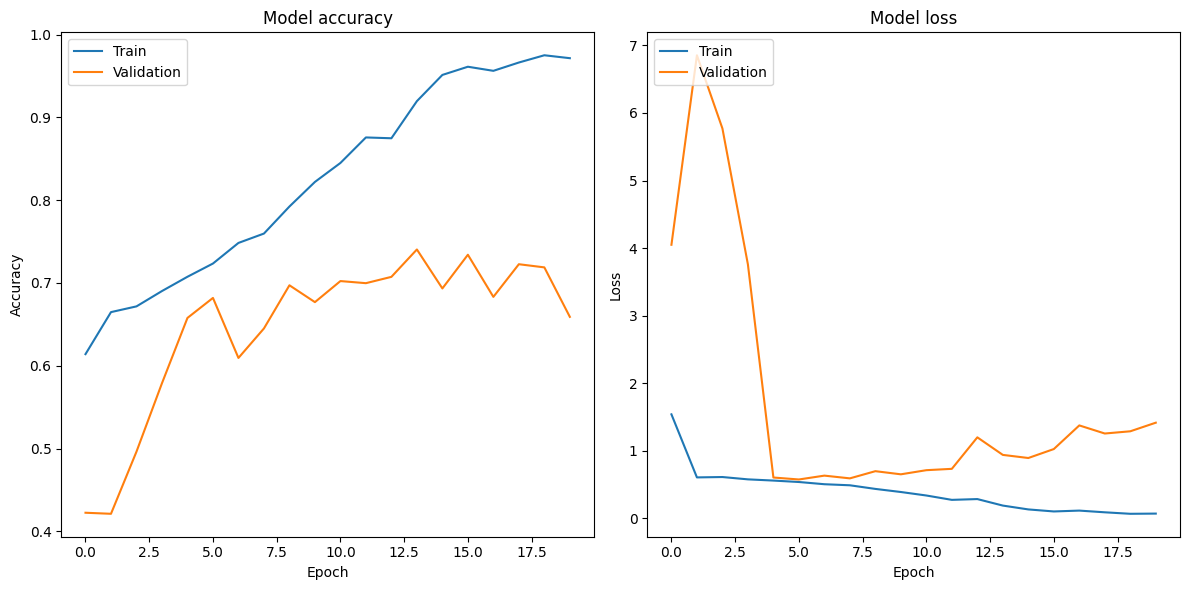

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_test1_64.history['accuracy'])
plt.plot(history_test1_64.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_test1_64.history['loss'])
plt.plot(history_test1_64.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


##Fitting and executing the Proposed model ( batch_size = 32)

In [29]:
# Fit the Proposed model
history_test1_32 = model_test1.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
221/221 [==============================] - 6s 27ms/step - loss: 0.2161 - accuracy: 0.9146 - val_loss: 1.2081 - val_accuracy: 0.7137
Epoch 2/20
221/221 [==============================] - 6s 26ms/step - loss: 0.1313 - accuracy: 0.9481 - val_loss: 0.8852 - val_accuracy: 0.7316
Epoch 3/20
221/221 [==============================] - 4s 19ms/step - loss: 0.0738 - accuracy: 0.9719 - val_loss: 1.4302 - val_accuracy: 0.7226
Epoch 4/20
221/221 [==============================] - 4s 17ms/step - loss: 0.0560 - accuracy: 0.9792 - val_loss: 5.1950 - val_accuracy: 0.5662
Epoch 5/20
221/221 [==============================] - 5s 23ms/step - loss: 0.0521 - accuracy: 0.9799 - val_loss: 1.3738 - val_accuracy: 0.7226
Epoch 6/20
221/221 [==============================] - 4s 17ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 1.3563 - val_accuracy: 0.7087
Epoch 7/20
221/221 [==============================] - 4s 16ms/step - loss: 0.0680 - accuracy: 0.9754 - val_loss: 1.5119 - val_accuracy: 0.7265

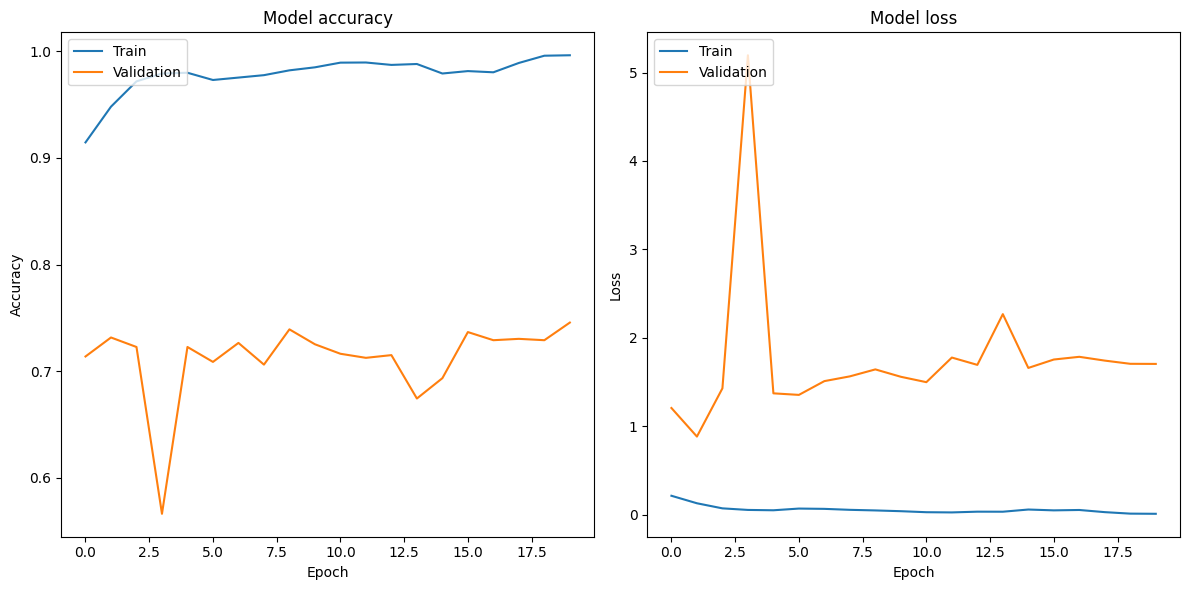

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_test1_32.history['accuracy'])
plt.plot(history_test1_32.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_test1_32.history['loss'])
plt.plot(history_test1_32.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## ROC curve

13/13 [==============================] - 0s 5ms/step


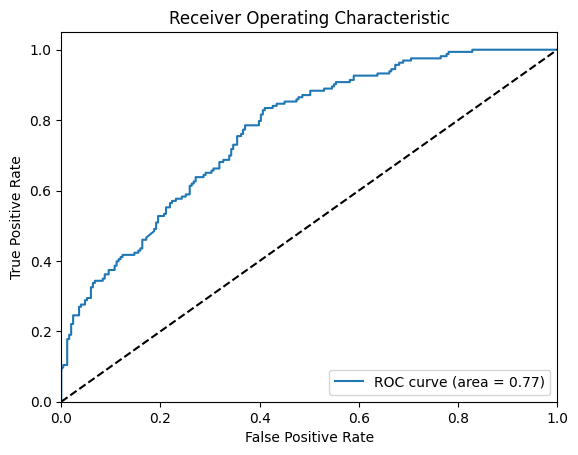

In [31]:
y_pred_prob = model_test1.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  # number of classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Analysing the model

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from keras.metrics import Precision, Recall

y_pred_prob = model_test1.predict(X_test)

y_pred_class = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test.argmax(axis=1), y_pred_class)

cr = classification_report(y_test.argmax(axis=1), y_pred_class, target_names=['AD', 'MCI'])

auc = roc_auc_score(y_test, model_test1.predict(X_test))

print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(cr)

print("AUC: ", auc)


13/13 [==============================] - 0s 5ms/step
Confusion Matrix:
[[190  61]
 [ 69  94]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.73      0.76      0.75       251
         MCI       0.61      0.58      0.59       163

    accuracy                           0.69       414
   macro avg       0.67      0.67      0.67       414
weighted avg       0.68      0.69      0.68       414

AUC:  0.7677327499816684


## Adding dropout to the model and analysing it

In [33]:
from keras.layers import Dropout

# Define the Testing model 1 with dropout
model_test1_dropout = Sequential([
    Input(shape=(128, 128, 1)),  # Adjusted input shape to match the data
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),  # Added dropout
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Softmax for output layer
])

# Use the legacy Adam optimizer
model_test1_dropout.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Now you can fit the model
history_test1_dropout = model_test1_dropout.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=20)


Epoch 1/20
111/111 [==============================] - 6s 50ms/step - loss: 1.6539 - accuracy: 0.5694 - val_loss: 18.3498 - val_accuracy: 0.4186
Epoch 2/20
111/111 [==============================] - 5s 49ms/step - loss: 0.6748 - accuracy: 0.5826 - val_loss: 23.5056 - val_accuracy: 0.4186
Epoch 3/20
111/111 [==============================] - 5s 48ms/step - loss: 0.6489 - accuracy: 0.5827 - val_loss: 20.8146 - val_accuracy: 0.4186
Epoch 4/20
111/111 [==============================] - 5s 49ms/step - loss: 0.6500 - accuracy: 0.5827 - val_loss: 25.5910 - val_accuracy: 0.4186
Epoch 5/20
111/111 [==============================] - 6s 53ms/step - loss: 0.6349 - accuracy: 0.5830 - val_loss: 4.4218 - val_accuracy: 0.4377
Epoch 6/20
111/111 [==============================] - 6s 58ms/step - loss: 0.6329 - accuracy: 0.5830 - val_loss: 1.5308 - val_accuracy: 0.5178
Epoch 7/20
111/111 [==============================] - 6s 51ms/step - loss: 0.6351 - accuracy: 0.5829 - val_loss: 0.7192 - val_accuracy: 0.

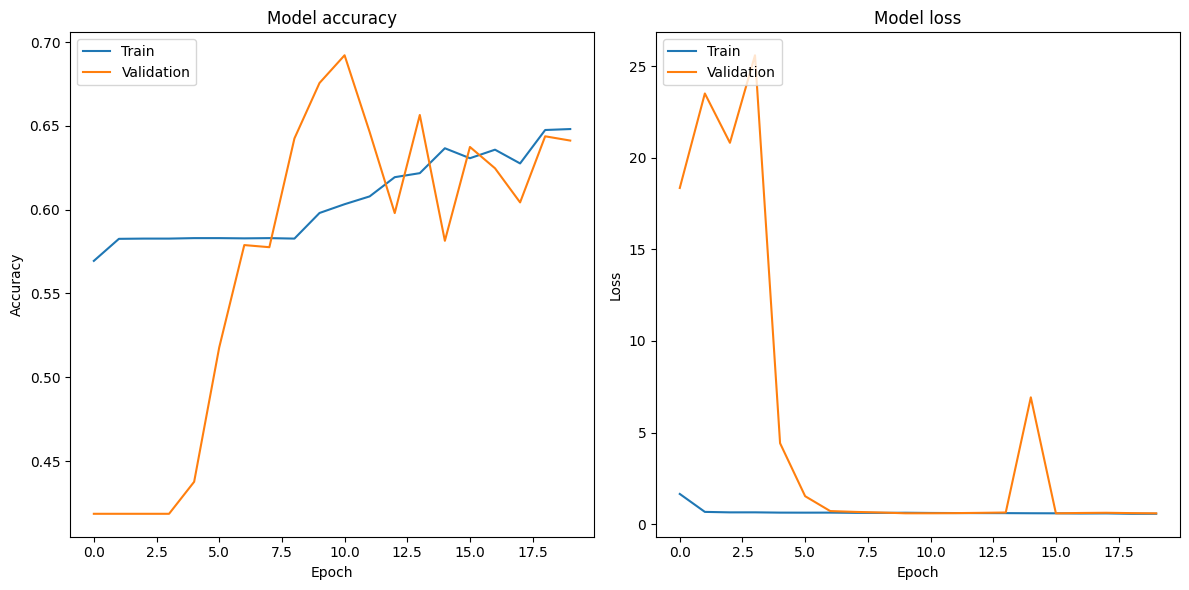

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_test1_dropout.history['accuracy'])
plt.plot(history_test1_dropout.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_test1_dropout.history['loss'])
plt.plot(history_test1_dropout.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()